In [97]:
!pip install pandas --quiet
!pip install seaborn --quiet

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
# Feature to Generate
target_features = {
    "State":{
        "categories":['California'],
        "prompt": "State of residence",
        "dtype":"category"
        },
        "Ethnicity Group":{
            "categories":["Latino", "White", "Asian/Pacific Islander", "Black", "Native American", "Multiracial/Other"],
            "dtype":"category"
            },
        "Age Group":{
            "categories":["Children (0-17)","College-going age (18-24)","Prime-working age (25-54)","Adults (55-64)","65 and older"],
            "dtype":"category"
        }
}

In [101]:
palette = list(np.flip(["#CA4F1A","#293B54","#CCCB74","#93D1E4","#A98BC0","#B3B3B1"]))

def plot_distribution(samples: pd.DataFrame, target_features: dict) -> None:
    samples['Age Group'] = pd.Categorical(samples['Age Group'], ["Children (0-17)","College-going age (18-24)","Prime-working age (25-54)","Adults (55-64)","65 and older"])
    hue_order = ["Latino", "White", "Asian/Pacific Islander", "Black", "Native American", "Multiracial/Other"]
    ax=sns.histplot(
        data=samples,
        y="Age Group", hue=("Race" if "Race" in samples.columns else "Ethnicity Group"), hue_order=np.flip(hue_order),palette=palette,
        multiple="fill", stat="proportion",
        discrete=True, shrink=.8
    )

    plt.xticks(rotation=45)
    sns.move_legend(ax, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=6, fancybox=False)

In [102]:
data = pd.read_parquet("/content/drive/MyDrive/data/DataLLMv2_paper/cell-generation_model-gpt-4o-mini_run_4.parquet")
data["Age Group"] = data["Age Group"].apply(lambda x: x.replace("–","-"))

In [103]:
data["Age Group"].unique()

array(['Prime-working age (25-54)', 'College-going age (18-24)'],
      dtype=object)

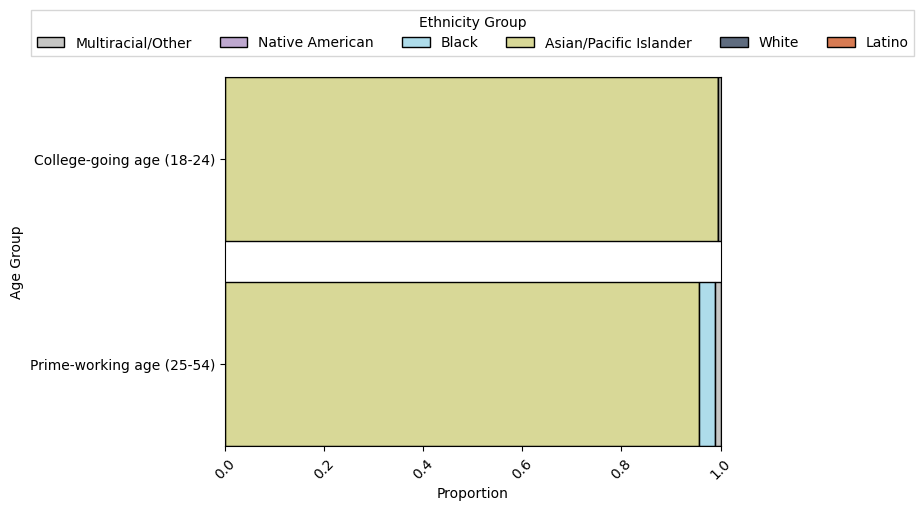

In [104]:
plot_distribution(data, target_features)

In [105]:
# results = data[["Age Group","Race"]].groupby("Age Group").value_counts(normalize=True).to_frame()

In [106]:
# Standardize and prepare data for each generation type
def standardize_df(df):
    # Map Ethnicity Group to Race, fix known issues
    eth_map = {
        'Latin': 'Latino', 'Latino': 'Latino',
        'White': 'White', 'Whit': 'White',
        'Asian/Pacific Islander': 'Asian/Pacific Islander',
        'Black': 'Black', 'African American': 'Black',
        'Native American': 'Native American', 'Natice American': 'Native American',
        'Multiracial/Other': 'Multiracial/Other', 'Multriracial/Other': 'Multiracial/Other', 'Mutiracial/Other': 'Multiracial/Other',
        'None': 'Multiracial/Other', 'Null': 'Multiracial/Other',
    }
    df = df.copy()
    df['Race'] = df['Race'].map(eth_map).fillna('Multiracial/Other')
    # Standardize Age Group
    age_map = {
        'Children (0-17)': 'Children (0-17)',
        'College-going age (18–24)': 'College-going age (18-24)',
        'College-going age (18-24)': 'College-going age (18-24)',
        'Collge-going age (18–24)': 'College-going age (18-24)',
        'Coloré-going age (18–24)': 'College-going age (18-24)',
        'Prime-working age (25–54)': 'Prime-working age (25-54)',
        'prime-working age (25–54)': 'Prime-working age (25-54)',
        'Adults (55–64)': 'Adults (55-64)',
        'Adult (55–64)': 'Adults (55-64)',
        '65 and older': '65 and older',
        '66 and older': '65 and older',
    }
    df['Age Group'] = df['Age Group'].map(age_map).fillna('Children (0-17)')
    return df


In [107]:
original_data = pd.DataFrame({
    'Race': ['Latino','Latino','Latino','Latino','Latino',
                        'White', 'White','White','White','White',
                        'Asian/Pacific Islander', 'Asian/Pacific Islander', 'Asian/Pacific Islander', 'Asian/Pacific Islander', 'Asian/Pacific Islander',
                        'Black', 'Black', 'Black', 'Black', 'Black',
                        'Native American', 'Native American', 'Native American', 'Native American', 'Native American',
                        'Multiracial/Other', 'Multiracial/Other', 'Multiracial/Other', 'Multiracial/Other', 'Multiracial/Other',
                        ],
    'Age Group': [
        'Children (0-17)', 'College-going age (18-24)', 'Prime-working age (25-54)', 'Adults (55-64)', '65 and older',
        'Children (0-17)', 'College-going age (18-24)', 'Prime-working age (25-54)', 'Adults (55-64)', '65 and older',
        'Children (0-17)', 'College-going age (18-24)', 'Prime-working age (25-54)', 'Adults (55-64)', '65 and older',
        'Children (0-17)', 'College-going age (18-24)', 'Prime-working age (25-54)', 'Adults (55-64)', '65 and older',
        'Children (0-17)', 'College-going age (18-24)', 'Prime-working age (25-54)', 'Adults (55-64)', '65 and older',
        'Children (0-17)', 'College-going age (18-24)', 'Prime-working age (25-54)', 'Adults (55-64)', '65 and older',
        ],
    'Proportion': [
        0.519, 0.502, 0.417, 0.325, 0.22,
        0.238, 0.264, 0.318, 0.424, 0.53,
        0.134, 0.135, 0.177, 0.167, 0.175,
        0.05, 0.053, 0.059, 0.062, 0.053,
        0.004, 0.004, 0.004, 0.005, 0.005,
        0.055, 0.042, 0.026, 0.017, 0.014
    ]
})
original_data = original_data.pivot(columns='Race', index='Age Group', values='Proportion')

In [108]:
def calculate_distribution(file_path):
  """Calculates the age-race distribution for a given file.

  Args:
      file_path: Path to the parquet file.

  Returns:
      A pandas DataFrame representing the distribution.
  """
  data = pd.read_parquet(file_path)
  if 'Ethnicity Group' in data.columns:
    data.rename({'Ethnicity Group':'Race'},axis=1,inplace=True)
    data = standardize_df(data)
  data["Age Group"] = data["Age Group"].apply(lambda x: x.replace("–", "-"))  # Ensure consistent age group format
  distribution = pd.crosstab(data['Age Group'], data['Race'], normalize='index')
  return distribution

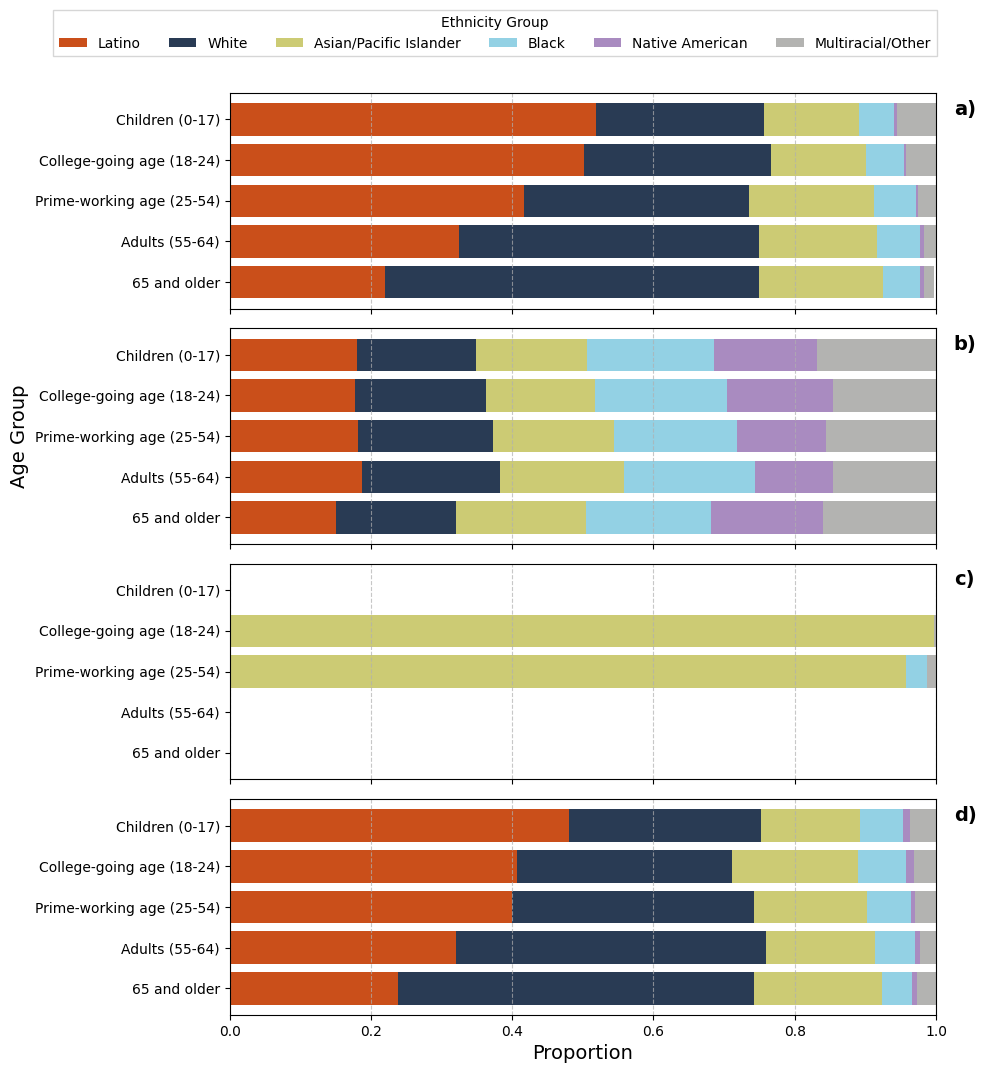

In [109]:
# Define the desired order for ethnicity and age groups
age_order = ["Children (0-17)","College-going age (18-24)","Prime-working age (25-54)","Adults (55-64)","65 and older"]
race_order = ["Latino", "White", "Asian/Pacific Islander", "Black", "Native American", "Multiracial/Other"]

fig, ax = plt.subplots(4,1,figsize=(10, 10), sharex=True)

for idx,method in enumerate(["original","one-shot-generation_model-gpt-4o-mini","cell-generation_model-gpt-4o-mini", "jennersdorfgpt_model_gpt-4o"]):
  if idx==0:
    average_distribution_df = original_data
  else:
    file_paths = [f"/content/drive/MyDrive/data/DataLLMv2_paper/{method}_run_{i}.parquet" for i in range(1, 6)]  # Assuming files are numbered 1 to 5
    distributions = [calculate_distribution(file_path) for file_path in file_paths]

    average_distribution = np.mean(distributions, axis=0)

    average_distribution_df = pd.DataFrame(average_distribution,
                                          index=distributions[0].index,  # Use the index from one of the distributions
                                          columns=distributions[0].columns)

  # Reorder the columns and index of the average_distribution_df
  average_distribution_df = average_distribution_df.reindex(columns=race_order)
  average_distribution_df = average_distribution_df.reindex(np.flip(age_order))

  # Create the horizontal stacked bar chart
  average_distribution_df.plot(kind='barh', stacked=True, ax=ax[idx], color=np.flip(palette), width=0.8)

  # Customize the plot (optional)
  # ax[idx].set_title(method, fontsize=16) # Increase title font size
  ax[idx].set_xlabel('Proportion' if idx == 3 else '', fontsize=14)
  ax[idx].set_ylabel('Age Group' if idx == 1 else '', fontsize=14)
  ax[idx].set_xlim([0,1])
  # Remove legend from all but top plot
  ax[idx].get_legend().remove()
  ax[idx].grid(axis='x', linestyle='--', alpha=0.7)

# plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
# plt.margins(0,0)

# Adjust layout
plt.subplots_adjust(top=0.9, bottom=0.1, right=0.95, left=0.1, hspace=0, wspace=0)

# Place legend outside of plots
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Ethnicity Group', loc='upper center', ncol=6, fancybox=False, bbox_to_anchor=(0.5, 1.075))
# Add labels to subplots
ax[0].text(1.025, 0.9, 'a)', transform=ax[0].transAxes, size=14, weight='bold')
ax[1].text(1.025, 0.9, 'b)', transform=ax[1].transAxes, size=14, weight='bold')
ax[2].text(1.025, 0.9, 'c)', transform=ax[2].transAxes, size=14, weight='bold')
ax[3].text(1.025, 0.9, 'd)', transform=ax[3].transAxes, size=14, weight='bold')
plt.tight_layout()


In [110]:
fig.savefig("/content/drive/MyDrive/data/DataLLMv2_paper/california_distibution.png", bbox_inches='tight')


In [111]:
average_distribution_df*100

Race,Latino,White,Asian/Pacific Islander,Black,Native American,Multiracial/Other
Age Group,,,,,,
65 and older,23.863883,50.416736,18.054909,4.322903,0.721931,2.619638
Adults (55-64),32.013572,43.885414,15.440633,5.681501,0.681561,2.297318
Prime-working age (25-54),39.953081,34.274600,16.009981,6.152770,0.643890,2.965677
College-going age (18-24),40.748145,30.433375,17.737815,6.815242,1.111552,3.153871
Children (0-17),48.073688,27.147600,13.984115,6.088105,1.029145,3.677346


In [112]:
std_deviation = np.std(distributions, axis=0)

In [113]:
std_deviation_df = pd.DataFrame(std_deviation,
                                 index=distributions[0].index,
                                 columns=distributions[0].columns)

In [114]:
std_deviation_df*100

Race,Asian/Pacific Islander,Black,Latino,Multiracial/Other,Native American,White
Age Group,,,,,,
65 and older,3.738739,1.038244,3.438301,0.322470,0.194023,5.760559
Adults (55-64),1.848862,0.300708,1.493795,0.427914,0.507937,2.254293
Children (0-17),1.251804,0.666383,1.811445,0.926895,0.741767,1.289390
College-going age (18-24),1.942342,0.891338,1.326855,0.868704,0.726059,2.226208
Prime-working age (25-54),0.936519,0.690223,2.174922,0.970759,0.277402,2.950032


In [115]:
# prompt: reformat the dataframe average_distribution_df in the form of results dataframe; update values in the table as the mean value plus-minus with corresponding standard deviation from the dataframe std_deviation_df

# Create the 'results' DataFrame with the same structure as 'average_distribution_df'
results = pd.DataFrame(index=average_distribution_df.index, columns=average_distribution_df.columns)

# Iterate through the rows and columns of the average_distribution_df
for index, row in average_distribution_df.iterrows():
    for column in average_distribution_df.columns:
        # Calculate the value with plus-minus standard deviation
        mean_value = average_distribution_df.loc[index, column]
        std_dev = std_deviation_df.loc[index, column]
        results.loc[index, column] = f"{round(100*mean_value,1):.1f} ± {round(100*std_dev,1):.1f}" # Format to 4 decimal places

# results


In [116]:
results

Race,Latino,White,Asian/Pacific Islander,Black,Native American,Multiracial/Other
Age Group,,,,,,
65 and older,23.9 ± 3.4,50.4 ± 5.8,18.1 ± 3.7,4.3 ± 1.0,0.7 ± 0.2,2.6 ± 0.3
Adults (55-64),32.0 ± 1.5,43.9 ± 2.3,15.4 ± 1.8,5.7 ± 0.3,0.7 ± 0.5,2.3 ± 0.4
Prime-working age (25-54),40.0 ± 2.2,34.3 ± 3.0,16.0 ± 0.9,6.2 ± 0.7,0.6 ± 0.3,3.0 ± 1.0
College-going age (18-24),40.7 ± 1.3,30.4 ± 2.2,17.7 ± 1.9,6.8 ± 0.9,1.1 ± 0.7,3.2 ± 0.9
Children (0-17),48.1 ± 1.8,27.1 ± 1.3,14.0 ± 1.3,6.1 ± 0.7,1.0 ± 0.7,3.7 ± 0.9


In [117]:
# Sort the index of the pivoted_results DataFrame
pivoted_results = results.T.unstack()
pivoted_results = pivoted_results.reindex(index=pd.MultiIndex.from_product([age_order, race_order], names=['Age Group', 'Race']))
pivoted_results


Age Group                  Race                  
Children (0-17)            Latino                    48.1 ± 1.8
                           White                     27.1 ± 1.3
                           Asian/Pacific Islander    14.0 ± 1.3
                           Black                      6.1 ± 0.7
                           Native American            1.0 ± 0.7
                           Multiracial/Other          3.7 ± 0.9
College-going age (18-24)  Latino                    40.7 ± 1.3
                           White                     30.4 ± 2.2
                           Asian/Pacific Islander    17.7 ± 1.9
                           Black                      6.8 ± 0.9
                           Native American            1.1 ± 0.7
                           Multiracial/Other          3.2 ± 0.9
Prime-working age (25-54)  Latino                    40.0 ± 2.2
                           White                     34.3 ± 3.0
                           Asian/Pacific Islander    16.0 ± 0.9
                           Black                      6.2 ± 0.7
                           Native American            0.6 ± 0.3
                           Multiracial/Other          3.0 ± 1.0
Adults (55-64)             Latino                    32.0 ± 1.5
                           White                     43.9 ± 2.3
                           Asian/Pacific Islander    15.4 ± 1.8
                           Black                      5.7 ± 0.3
                           Native American            0.7 ± 0.5
                           Multiracial/Other          2.3 ± 0.4
65 and older               Latino                    23.9 ± 3.4
                           White                     50.4 ± 5.8
                           Asian/Pacific Islander    18.1 ± 3.7
                           Black                      4.3 ± 1.0
                           Native American            0.7 ± 0.2
                           Multiracial/Other          2.6 ± 0.3
dtype: object